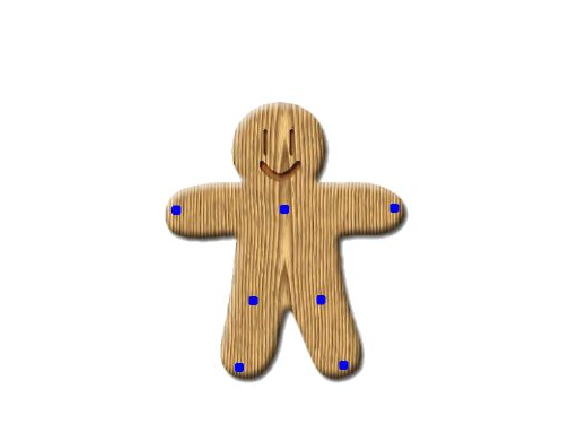

In [1]:
image = imread("math-expt/imgs/l12_toy.jpg");
rawP = [155 30; 155 125; 155 225; 235 100; 235 160; 295 85; 293 180];
rawQ = [211 42; 155 125; 100 235; 235 80; 235 140; 295 85; 295 180];

gridX = 1:size(image, 2);
gridY = 1:size(image, 1);
[Y, X] = meshgrid(gridX, gridY);

imshow(image);

In [2]:
Q = rawP;
P = rawQ;

numRow = size(X, 1);
numCol = size(X, 2);
numN = size(P, 1);

In [3]:
V = cat(3, X, Y); % [numRow, numCol, 2]
nV = repmat(reshape(V, [1, numRow, numCol, 2]), [numN, 1, 1, 1]); % [numN, numRow, numCol, 2]
nP = repmat(reshape(P, [numN, 1, 1, 2]), [1, numRow, numCol, 1]); % [numN, numRow, numCol, 2]
nQ = repmat(reshape(Q, [numN, 1, 1, 2]), [1, numRow, numCol, 1]); % [numN, numRow, numCol, 2]

In [4]:
eps = 1e-8;
alpha = 1.0;

snWeight = 1.0 / (sum((nP - nV) .^ 2, 4) + eps) .^ alpha; % [numN, numRow, numCol]
snWeight = snWeight ./ sum(snWeight, 1);
nWeight = repmat(snWeight, [1, 1, 1, 2]); % [numN, numRow, numCol, 2]

In [5]:
P_star = squeeze(sum(nP .* nWeight, 1)); % [numRow, numCol, 2]
nP_star = repmat(reshape(P_star, [1, numRow, numCol, 2]), [numN, 1, 1, 1]); % [numN, numRow, numCol, 2]
Q_star = squeeze(sum(nQ .* nWeight, 1)); % [numRow, numCol, 2]
nQ_star = repmat(reshape(Q_star, [1, numRow, numCol, 2]), [numN, 1, 1, 1]); % [numN, numRow, numCol, 2]

nP_hat = nP - nP_star; % [numN, numRow, numCol, 2]
nP_hat_T = reshape(nP_hat, [numN, numRow, numCol, 1, 2]); % [numN, numRow, numCol, 1, 2]
nQ_hat = nQ - nQ_star; % [numN, numRow, numCol, 2] 

rnP_hat = repmat(nP_hat, [1, 1, 1, 1, 2]); % [numN, numRow, numCol, 2, 2]
rnP_hat_T = repmat(nP_hat_T, [1, 1, 1, 2, 1]); % [numN, numRow, numCol, 2, 2]

nPT_W_P = nWeight .* rnP_hat .* rnP_hat_T; % [numN, numRow, numCol, 2, 2]
PT_W_P = squeeze(sum(nPT_W_P, 1)); % [numRow, numCol, 2, 2]

In [6]:
sMu = squeeze(sum(snWeight .* sum(nP_hat .^ 2,4),1)); % [numRow, numCol]
Mu = repmat(sMu, [1, 1, 2]); % [numRow, numCol, 2]

### 1. affine_deformed

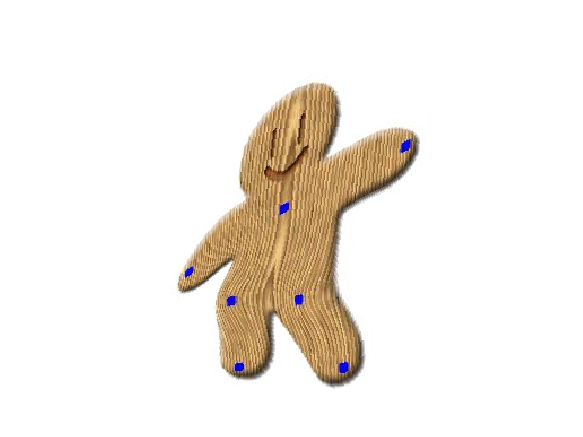

In [7]:
Left = (V - P_star); % [numRow, numCol, 2]
nLeft = repmat(reshape(Left, [1, numRow, numCol, 2]), [numN, 1, 1, 1]); % [numN, numRow, numCol, 2]

Inv_PT_W_P = zeros([numRow, numCol, 2, 2]);
for i = 1:numRow
    for j = 1:numCol
        subMatrix = squeeze(PT_W_P(i, j, :, :));
        Inv_PT_W_P(i, j, :, :) = inv(subMatrix);
    end
end
nInv_PT_W_P = repmat(reshape(Inv_PT_W_P, [1, numRow, numCol, 2, 2]), [numN, 1, 1, 1, 1]); % [numN, numRow, numCol, 2, 2]

nRight = nWeight .* nP_hat; % [numN, numRow, numCol, 2]

nsA = zeros([numN, numRow, numCol]);
for k = 1:numN
    for i = 1:numRow
        for j = 1:numCol
            subMatrixL = squeeze(nLeft(k, i, j, :));
            subMatrixInv = squeeze(nInv_PT_W_P(k, i, j, :, :));
            subMatrixR = squeeze(nRight(k, i, j, :, :));

            nsA(k, i, j) = subMatrixL' * subMatrixInv * subMatrixR;
        end
    end
end

transformed = zeros([numRow, numCol, 2]);
for k = 1:numN
    transformed = transformed + squeeze(nsA(k, :, :, :)) .* (squeeze(nQ(k, :, :, :)) - Q_star);
end

transformed = transformed + Q_star;

affine_deformed = zeros(size(image));

for i = 1:numRow
    for j = 1:numCol
        x = transformed(i, j, 2);
        y = transformed(i, j, 1);
        if x >= 1 && x <= numCol && y >= 1 && y <= numRow
            affine_deformed(i, j, :) = image(round(y), round(x), :);
        else
            affine_deformed(i, j, :) = 255;
        end
    end
end

imshow(affine_deformed / 255);

### 2. similartity_deformed

In [8]:
VP_star = V - P_star;
Neg_VP_star = zeros([numRow, numCol, 2]);
for i=1:numRow
    for j=1:numCol
        Neg_VP_star(i,j,1) = VP_star(i,j,2);
        Neg_VP_star(i,j,2) = - VP_star(i,j,1);
    end
end
Right = cat(4, VP_star, Neg_VP_star); % [numRow, numCol, 2, 2]

temp = zeros([numRow, numCol, 2]);
for k=1:numN
    phat = squeeze(nP_hat(k,:,:,:));
    neg_phat = zeros([numRow,numCol,2]);
    for i=1:numRow
        for j=1:numCol
            neg_phat(i,j,1) = phat(i,j,2);
            neg_phat(i,j,2) = - phat(i,j,1);
        end
    end
    
    Left = cat(4,phat, neg_phat);
    Left_handled = (squeeze(nWeight(k,:,:,:)) .* Left);
    A = zeros([numRow,numCol,2]);
    for i=1:numRow
        for j=1:numCol
            temp_nQ_hat = reshape(squeeze(nQ_hat(k,i,j,:)), [1,2]); 
            A(i,j,:) = temp_nQ_hat * (squeeze(Left_handled(i,j,:,:)) * squeeze(Right(i,j,:,:)));
        end
    end
    
    temp = temp + A;
end


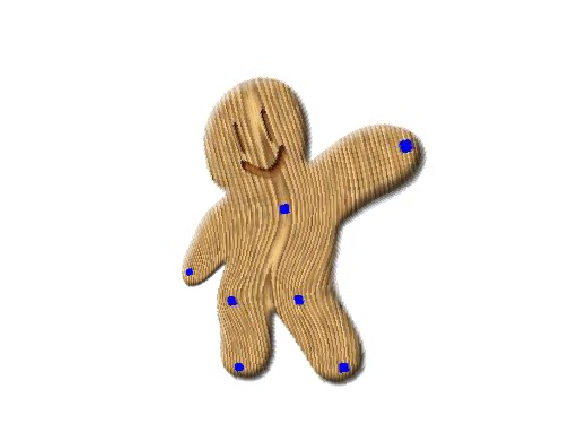

In [9]:
transformed = temp ./ Mu + Q_star;

similartity_deformed = zeros(size(image));

for i = 1:numRow
    for j = 1:numCol
        x = transformed(i, j, 2);
        y = transformed(i, j, 1);
        if x >= 1 && x <= numCol && y >= 1 && y <= numRow
            similartity_deformed(i, j, :) = image(round(y), round(x), :);
        else
            similartity_deformed(i, j, :) = 255;
        end
    end
end

imshow(similartity_deformed / 255);